# **Cointegration Testing Analysis and Decision Tree Modeling for the AMZN Stock**
## In this notebook we start to bring things together from other sections of the project.  We combine our analyzed and preprocessed core_stock_data with our preprocessed and dynamically generated secondary stock data to perform cointegration testing to see if we can create cointegrated pairs, which we will add as separate features to use for our Decision Tree model.  We will also merge in our exogenous data for this Decision Tree model, data we haven't talked about a whole lot yet.  This data will aid in adding in another layer to the stock chains we want to create at the end output at the end of the Decision Tree based on their relationships.  We will use the output of the Decision Tree to read into how the stocks work with each other so we can start to formulate our trading strategy in the next step.

#### As with our other notebooks let's read in our data to use for this.  This time let's take a good look at the shape of our dataframes since we will plan on merging them later on in the notebook.  It will be important that the dataframes match in size so that modeling works for our Decision Trees.  If they mismatch we will have to investigate.

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import plot_tree

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Now let's access the main core_stock_data.csv file, as well as the secondary stock data and exo_data to all be used in this notebook!
csv_path = os.path.join(project_root, 'data', 'core_stock_unscaled.csv')
core_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
print(core_stock_data.head())
print(core_stock_data.shape)

csv_path = os.path.join(project_root, 'data', 'secondary_stocks_gen_filtered.csv')
sec_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
print(sec_stock_data.head())
print(sec_stock_data.shape)

csv_path = os.path.join(project_root, 'data', 'exo_data_unscaled.csv')
exo_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')

print(exo_data.head())
print(exo_data.shape)




            Close_core  Volume_core  Open_core  High_core   Low_core  \
Date                                                                   
2019-03-14   45.932499   94318000.0  45.974998  46.025002  45.639999   
2019-03-15   46.529999  156171600.0  46.212502  46.832500  45.935001   
2019-03-18   47.005001  104879200.0  46.450001  47.097500  46.447498   
2019-03-19   46.632500  126585600.0  47.087502  47.247501  46.480000   
2019-03-20   47.040001  124140800.0  46.557499  47.372501  46.182499   

            SMA_core   EMA_core   RSI_core  BBM_core   BBU_core  ...  \
Date                                                             ...   
2019-03-14  41.35925  42.219051  75.741602  41.35925  46.695085  ...   
2019-03-15  41.50025  42.388107  76.985910  41.50025  47.003365  ...   
2019-03-18  41.72940  42.569162  78.724282  41.72940  47.174667  ...   
2019-03-19  41.92075  42.728509  73.527018  41.92075  47.369412  ...   
2019-03-20  42.12190  42.897587  80.396901  42.12190  47.569044

In [3]:
exo_only_dates = exo_data.index.difference(core_stock_data.index)
print(exo_only_dates)



DatetimeIndex(['2019-04-19', '2019-05-27', '2019-07-04', '2019-09-02',
               '2019-11-28', '2019-12-25', '2020-01-01', '2020-01-20',
               '2020-02-17', '2020-04-10', '2020-05-25', '2020-07-03',
               '2020-09-07', '2020-11-26', '2020-12-25', '2021-01-01',
               '2021-01-18', '2021-02-15', '2021-04-02', '2021-05-31',
               '2021-07-05', '2021-09-06', '2021-11-25', '2021-12-24',
               '2022-01-17', '2022-02-21', '2022-04-15', '2022-05-30',
               '2022-06-20', '2022-07-04', '2022-09-05', '2022-11-24',
               '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20',
               '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04',
               '2023-09-04', '2023-11-23', '2023-12-25', '2024-01-01',
               '2024-01-15', '2024-02-19', '2024-03-29', '2024-05-27',
               '2024-06-19', '2024-07-04'],
              dtype='datetime64[ns]', name='Date', freq=None)


#### Now let's grab just our AMZN stock for this notebook.

In [4]:
# We will want to preserve this version of our data since we will be using this data specifically for our modeling target, so we will want to keep it isolated.
amzn_data_orig = core_stock_data[core_stock_data['Ticker'] == 'AMZN'].copy()


amzn_data_orig.shape

(1365, 153)

#### Now looking back at exo_data I see a mismatch in our data.  Sec_stock_data is a different story as we still need it as it for now, and we will look at it later.  For now though let's look into exo_data and fix.

In [5]:
exo_only_dates = exo_data.index.difference(amzn_data_orig.index)
print(exo_only_dates)

DatetimeIndex(['2019-04-19', '2019-05-27', '2019-07-04', '2019-09-02',
               '2019-11-28', '2019-12-25', '2020-01-01', '2020-01-20',
               '2020-02-17', '2020-04-10', '2020-05-25', '2020-07-03',
               '2020-09-07', '2020-11-26', '2020-12-25', '2021-01-01',
               '2021-01-18', '2021-02-15', '2021-04-02', '2021-05-31',
               '2021-07-05', '2021-09-06', '2021-11-25', '2021-12-24',
               '2022-01-17', '2022-02-21', '2022-04-15', '2022-05-30',
               '2022-06-20', '2022-07-04', '2022-09-05', '2022-11-24',
               '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20',
               '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04',
               '2023-09-04', '2023-11-23', '2023-12-25', '2024-01-01',
               '2024-01-15', '2024-02-19', '2024-03-29', '2024-05-27',
               '2024-06-19', '2024-07-04'],
              dtype='datetime64[ns]', name='Date', freq=None)


#### There are 50 different dates and values that our exo_data has that our core target data does not.  Upon first glance they appear to be related to holidays.  Let's remove these values from exo_data so that the indices align.

In [6]:
exo_data_cleaned = exo_data.drop(index = exo_only_dates)

# Now re-check shape
print(f"Exo_data shape after dropping extra values: {exo_data_cleaned.shape}")


Exo_data shape after dropping extra values: (1365, 180)


#### Now we are ready.  We have our core stock and our secondary stock data.  Before we do the cointegration tests we will perform a ADF (Augmented Dickey-Fuller) test to check for stationarity.  This will help our cointegration results.

In [7]:

# Perform ADF Test on the 'Close' price column
adf_result = adfuller(amzn_data_orig['Close_core'])

# Display ADF test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])




ADF Statistic: -1.8255627488254622
p-value: 0.3678463670510293
Critical Values: {'1%': -3.435153261837347, '5%': -2.8636612797849814, '10%': -2.567899369049974}


#### Let's break down our results.  The ADF Statistic as a negative number is expected and a higher negative number here suggests stronger evidence against our hypothesis that the data is non-stationary.  The output here is fairly large which means the data is very likely to be stationary.  For the p value a value of 0 can occur when the ADF statistic is very large.  This value also aids in showing that the data is stationary.  Finally for the critical values as all being negative as well, this again shows that we can reject the null hypothesis and safely say that our core data is stationary and move on with the next phase of the notebook.

#### Now since there are 200 stocks in our secondary stock data we will need to make a function to process the tests more efficiently.

In [8]:
# Let's make a function that runs the test for our core stock for each secondary stock we have generated.
def cointegration_test(core_stock_data, sec_stock_data, core_ticker):
    results = []
    
    core_data = core_stock_data[core_stock_data['Ticker'] == core_ticker]['Close_core']
    
    secondary_tickers = sec_stock_data['ticker'].unique()
    
    for ticker in secondary_tickers:
        sec_data = sec_stock_data[sec_stock_data['ticker'] == ticker]['Close_sec']
        
        # As a check ensure the lengths match by trimming the larger series (if needed)
        min_len = min(len(core_data), len(sec_data))
        core_trimmed = core_data.iloc[-min_len:]
        sec_trimmed = sec_data.iloc[-min_len:]
        
        # Perform the cointegration test.
        coint_t, p_value, critical_values = coint(core_trimmed, sec_trimmed)
        
        # Append results to our results list
        results.append({
            'Secondary_Ticker' : ticker,
            'T-Statistic' : coint_t,
            'P_value' : p_value,
            'Critical_Values' : critical_values,
            'Cointegrated' : p_value < 0.05 # True if cointegrated
        })

    # Convert the results into a dataframe
    results_df = pd.DataFrame(results)
    
    return results_df

# Call the function now and perform cointegration testing on subject core stock and all secondary stocks
results_df = cointegration_test(core_stock_data, sec_stock_data, core_ticker='AMZN')

print(results_df)

# Filter and display only the cointegrated pairs
cointegrated_pairs = results_df[results_df['Cointegrated'] == True]
print("\nCointegrated Pairs:")
print(cointegrated_pairs)


    Secondary_Ticker  T-Statistic   P_value  \
0                RMD    -1.852532  0.603873   
1               AMAT    -1.948919  0.555007   
2               JNPR    -1.909657  0.575101   
3               DECK    -2.010079  0.523335   
4                JBL    -1.845208  0.607515   
..               ...          ...       ...   
195               ON    -1.729824  0.663141   
196             SWKS    -1.665260  0.692576   
197              MCD    -1.733896  0.661240   
198             ADSK    -2.917063  0.131259   
199                A    -1.895593  0.582241   

                                       Critical_Values  Cointegrated  
0    [-3.9044872726627737, -3.340613212756168, -3.0...         False  
1    [-3.9044872726627737, -3.340613212756168, -3.0...         False  
2    [-3.9044872726627737, -3.340613212756168, -3.0...         False  
3    [-3.9044872726627737, -3.340613212756168, -3.0...         False  
4    [-3.9044872726627737, -3.340613212756168, -3.0...         False  
..       

#### Neat!  Out of our 200 secondary stocks that we generated and preprocessed, we have 3 cointegration pairs with our core stock!  For this notebook using AMZN as our core stock it looks like just DPZ (Domino's Pizza Inc) is the only cointegrated pairs as their p-value is less than 0.05 which is the deterministic stat for the cointegration test.

#### We will now do the same cointegration test on our exogenous features.

In [9]:
# Let's make a function that runs the test for our core stock for each secondary stock we have generated.
def cointegration_test(core_stock_data, exo_data_cleaned, core_ticker):
    results = []
    
    core_data = core_stock_data[core_stock_data['Ticker'] == core_ticker]['Close_core']
    
    exo_features = ['nasdaq_100', 'sp500', 'interest_rates_10yr', 'gold', 'copper', 'platinum', 'silver', 'crude_oil', 'natural_gas', 'corn', 'wheat', 'volatility_index', 'exchange_rate_usd_eur', 'exchange_rate_usd_jpy', 'dow_jones_industrial_average', 'consumer_confidence_index', 'vanguard_total_world_stock_etf', 'us_treasury_bond_etf']
    
    for feature in exo_features:
        exo_series = exo_data_cleaned[feature]
        
        # Perform the cointegration test.
        coint_t, p_value, critical_values = coint(core_data, exo_series)
        
        # Append results to our results list
        results.append({
            'Exogenous_Feature' : feature,
            'T-Statistic' : coint_t,
            'P_value' : p_value,
            'Critical_Values' : critical_values,
            'Cointegrated' : p_value < 0.05 # True if cointegrated
        })

    # Convert the results into a dataframe
    results_df = pd.DataFrame(results)
    
    return results_df

# Call the function now and perform cointegration testing on subject core stock and all secondary stocks
results_df_exo = cointegration_test(core_stock_data, exo_data_cleaned, core_ticker='AMZN')

print(results_df_exo)

# Filter and display only the cointegrated pairs
cointegrated_exo = results_df_exo[results_df_exo['Cointegrated'] == True]

# In case no cointegration is found, we need some error logic.
if cointegrated_exo.empty:
    print("No exogenous features are cointegrated with our core ticker.")
else:
    print("\nCointegrated Exogenous Pairs:")
    print(cointegrated_exo)




                 Exogenous_Feature  T-Statistic   P_value  \
0                       nasdaq_100    -1.819485  0.620210   
1                            sp500    -1.801034  0.629220   
2              interest_rates_10yr    -1.817051  0.621403   
3                             gold    -2.396899  0.326325   
4                           copper    -2.090214  0.481484   
5                         platinum    -2.034949  0.510370   
6                           silver    -3.178746  0.073555   
7                        crude_oil    -1.833011  0.613553   
8                      natural_gas    -1.828959  0.615552   
9                             corn    -1.786182  0.636409   
10                           wheat    -1.764096  0.646992   
11                volatility_index    -1.781133  0.638841   
12           exchange_rate_usd_eur    -2.020965  0.517664   
13           exchange_rate_usd_jpy    -1.864417  0.597939   
14    dow_jones_industrial_average    -1.943770  0.557655   
15       consumer_confid

#### Unfortunately none of our exogenous features are cointegrated with our core ticker in this notebook at this time.  At another time we can look at expanding on our list of features in this space or the time period used but right now we will just move forward.

#### Ok time for our Decision Tree models.  We have a lot of setup to do for them first too.  We need to rename our ticker feature columns in our core_stock_ and sec_stock_data dataframes so they don't overwrite each other when a merge is applied (will apply these here below).  Also since we talked about previously the dataframe indices matching now is the time to talk about our sec_stock_data.  We will just use our cointegrated_pairs for our Decision Tree modeling, though however many pairs we have is x that many indices of data worth of our target.  So rather than unnecessary align or prune it down, we will just do a separate tree for each cointegrated pair, and then look at bringing them together afterwards.

In [10]:
# First let's rename our two columns.
core_stock_data.rename(columns = {'Ticker' : 'core_ticker'}, inplace = True)
sec_stock_data.rename(columns = {'ticker' : 'sec_ticker'}, inplace = True)

# Now let's make a variable that we can use for our cointegrated pairs
cointegrated_stocks = ['DPZ'] # To be edited for each core stock's results.

sec_stock_data.head()




,sec_ticker,Close_sec,Volume_sec,Open_sec,High_sec,Low_sec,SMA_sec,EMA_sec,RSI_sec,BBM_sec,...,Momentum_7_Lag_Avg_1_3_sec,Momentum_7_Lag_Std_1_3_sec,Momentum_30_Lag_Avg_1_3_sec,Momentum_30_Lag_Std_1_3_sec,Momentum_50_Lag_Avg_1_3_sec,Momentum_50_Lag_Std_1_3_sec,OBV_Lag_Avg_1_3_sec,OBV_Lag_Std_1_3_sec,Diff_Close_EMA_sec,Ratio_Close_EMA_sec
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-14,RMD,101.000000,972500.0,102.570000,102.570000,100.959999,104.9046,101.000000,63.818062,104.9046,...,0.419998,1.000000e-10,2.940002,1.000000e-10,12.889999,1.000000e-10,1.000000e-10,1.611779e+06,1.000000e-10,1.000000
2019-03-15,RMD,100.370003,2279400.0,100.900002,101.730003,100.199997,104.9046,100.975294,63.818062,104.9046,...,0.419998,1.000000e-10,2.940002,1.000000e-10,12.889999,1.000000e-10,1.000000e-10,1.611779e+06,1.000000e-10,0.994006
2019-03-18,RMD,97.400002,1915700.0,100.360001,100.610001,96.940002,104.9046,100.835087,63.818062,104.9046,...,0.419998,1.000000e-10,2.940002,1.000000e-10,12.889999,1.000000e-10,1.000000e-10,1.611779e+06,1.000000e-10,0.965934
2019-03-19,RMD,97.900002,1101100.0,97.660004,98.190002,97.070000,104.9046,100.719985,63.818062,104.9046,...,0.419998,1.000000e-10,2.940002,1.000000e-10,12.889999,1.000000e-10,1.000000e-10,2.100176e+06,1.000000e-10,0.972002
2019-03-20,RMD,98.809998,1467600.0,99.129997,100.800003,98.449997,104.9046,100.645084,63.818062,104.9046,...,0.419998,1.000000e-10,2.940002,1.000000e-10,12.889999,1.000000e-10,1.000000e-10,9.614140e+05,1.000000e-10,0.981767


#### The changes have been applied, and we are now ready to start preparing and building our models.

#### We will now set up our X,y for the model.  Similar to how we did for the Linear Regression models in this project we will eschew the traditional train_test_split methodology in favor of a more straightforward approach that works well with time series data.  We will also be using our cointegrated stocks here along with their data in the sec_stock_data dataframe and leaving the rest behind, and then adding the exo_data (exogenous data) to the mix to see what may be added here to the tree.

In [11]:

# Let's set up our Decision Tree model and get it ready.
# We have to do some prep work here.  We have our core data and cointegrated pairs that we have to make sure make it to X.

# To hopefully improve our net metric scores and reduce noise in the model we will utilize our optimized features we acquired using our VIF and correlation matrix analysis in a previous notebook, that was also use to generate our sec_stock_data stocks.
optimized_features = ['Volume_sec', 'Momentum_30_sec', 'MACD_Lag_Std_1_3_sec', 'MACD_Hist_Lag_Std_1_3_sec', 'MACD_Signal_Lag_Std_1_3_sec', 'Momentum_1_Lag_Std_1_3_sec', 'Momentum_3_Lag_Std_1_3_sec', 'Momentum_7_Lag_Std_1_3_sec', 'Momentum_30_Lag_Std_1_3_sec', 'Momentum_50_Lag_Std_1_3_sec']
# Let's first get the cointegrated stocks as a variable so we can use to grab their data from sec_stock_data.
cointegrated_stocks = ['DPZ']

# Loop over each cointegrated stock to build a separate tree
for stock in cointegrated_stocks:
    print(f"Building Decision Tree for {stock}")

    # Let's filter our sec_stock_data for rows where the ticker is included in our cointegrated_tickers so we can grab that data together.
    sec_stock_filtered = sec_stock_data[sec_stock_data['sec_ticker'] == stock]
    
    # Setting up X with the cointegrated stock data that has the excluded features.
    X = sec_stock_filtered[optimized_features]
    
    # Ensure all datatypes for our X are numeric
    X = X.apply(pd.to_numeric, errors = 'coerce')
    y = amzn_data_orig['Close_core'] # Our target
    
    

    # Not done yet, we are going to use split_index for Time Series on our X and y.
    split_index = int(len(X) * 0.8)

    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    # Let's check shapes of X and y to make sure
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape{y_train.shape}, y_test shape: {y_test.shape}")
    
    # Set up the Decision Tree model itself.
    dec_tree = DecisionTreeRegressor(random_state=42)

    # Set up the parameter grid for tuning if needed.
    param_grid = {
        'max_depth' : [2, 3, 5],
        'min_samples_split' : [10, 20],
        'min_samples_leaf' : [5, 10]
    }

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(dec_tree, param_grid, cv = 3, scoring = 'neg_mean_squared_error', n_jobs = -1)

    # Fit the model.
    grid_search.fit(X_train, y_train)
    
    best_tree = grid_search.best_estimator_

    best_tree.fit(X_train, y_train)

    # Now we can make predictions
    y_train_pred = best_tree.predict(X_train)
    y_test_pred = best_tree.predict(X_test)
    
    # Let's calculate the RMSE first.
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Let's now calculate the MAPE.
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

    # Now for the R2 scores.
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Lastly the Adjusted R2 score.
    def adjusted_r2(r2, X):
        n = len(X)
        p = X.shape[1]
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    adj_r2_train = adjusted_r2(r2_train, X_train)
    adj_r2_test = adjusted_r2(r2_test, X_test)

    print(f"Train RMSE:", rmse_train)
    print(f"Test RMSE:", rmse_test)

    print(f"Train MAPE:", mape_train)
    print(f"Test MAPE:", mape_test)

    print(f"Train R2:", r2_train)
    print(f"Test R2:", r2_test)

    print(f"Train Adj R2:", adj_r2_train)
    print(f"Test Adj R2:", adj_r2_test)
    
    # Now finally adding cross_validation to evaluate model stability
    cv_scores = cross_val_score(best_tree, X, y, cv = 5, scoring = 'neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    print(f"Cross-Validation RMSE scores: {cv_rmse}")
    print(f"Mean Cross-Validation RMSE: {cv_rmse.mean()}")
    

Building Decision Tree for DPZ
X_train shape: (1092, 10), X_test shape: (273, 10)
y_train shape(1092,), y_test shape: (273,)
Train RMSE: 28.86484688115782
Test RMSE: 36.90568890714921
Train MAPE: 20.67867294592321
Test MAPE: 17.91909778396886
Train R2: 0.17389495014949707
Test R2: -1.742048846381984
Train Adj R2: 0.16625290528501502
Test Adj R2: -1.846707199297327
Cross-Validation RMSE scores: [49.47464837 28.63566958 31.27738213 36.43624239 36.90568891]
Mean Cross-Validation RMSE: 36.54592627542871


#### Plot metrics obs.

#### Now let's look at a few plots based on our Decision Tree model.  First let's just take a look at the tree itself.

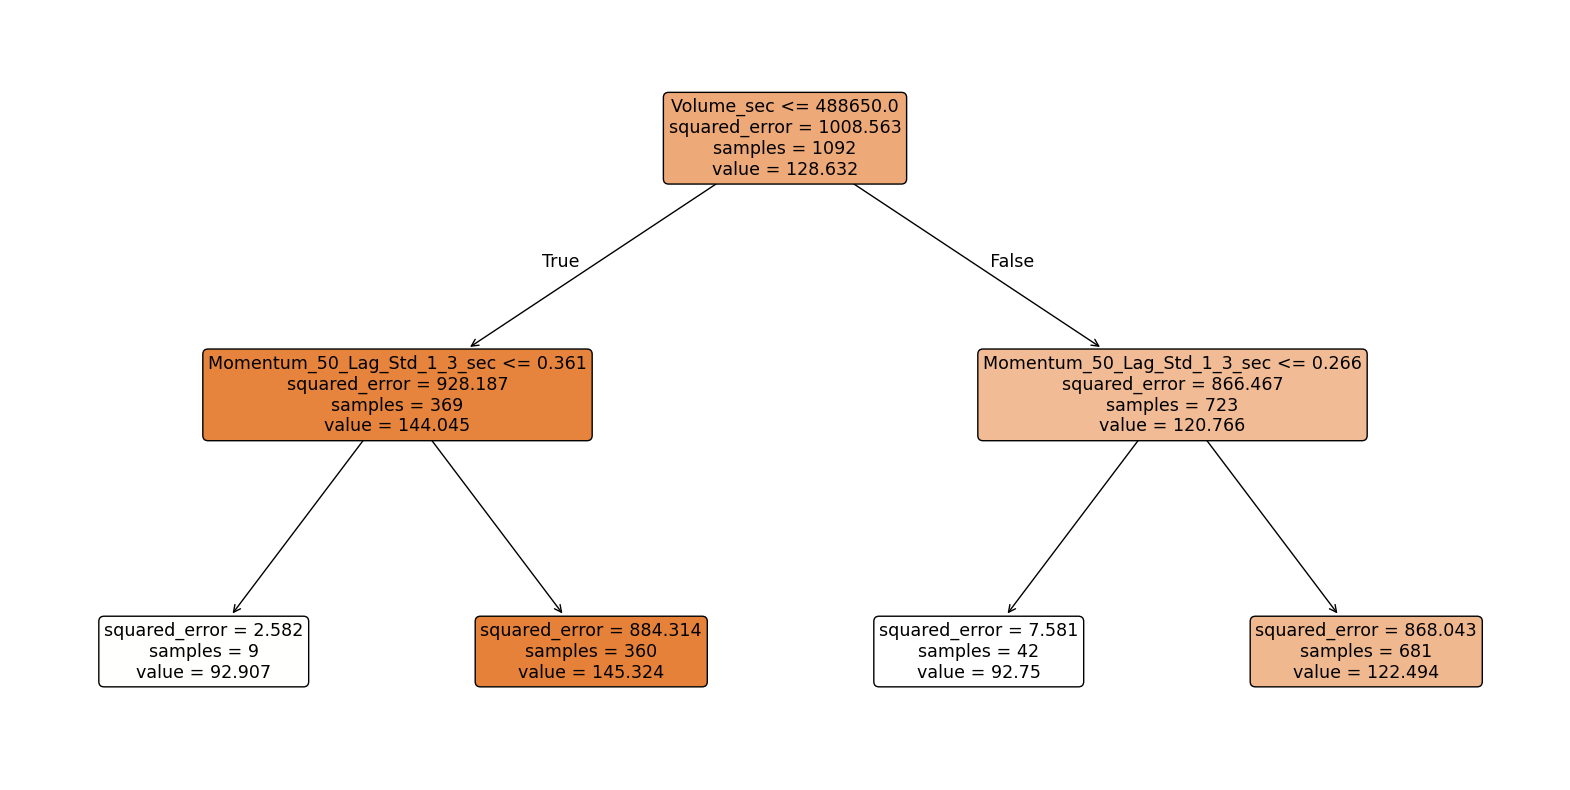

In [12]:
plt.figure(figsize = (20, 10))

plot_tree(best_tree, feature_names = X.columns, filled = True, rounded = True)
plt.show()

#### Plot observation.

#### Now let's look at another plot regarding feature importance to see how the model is using the data.

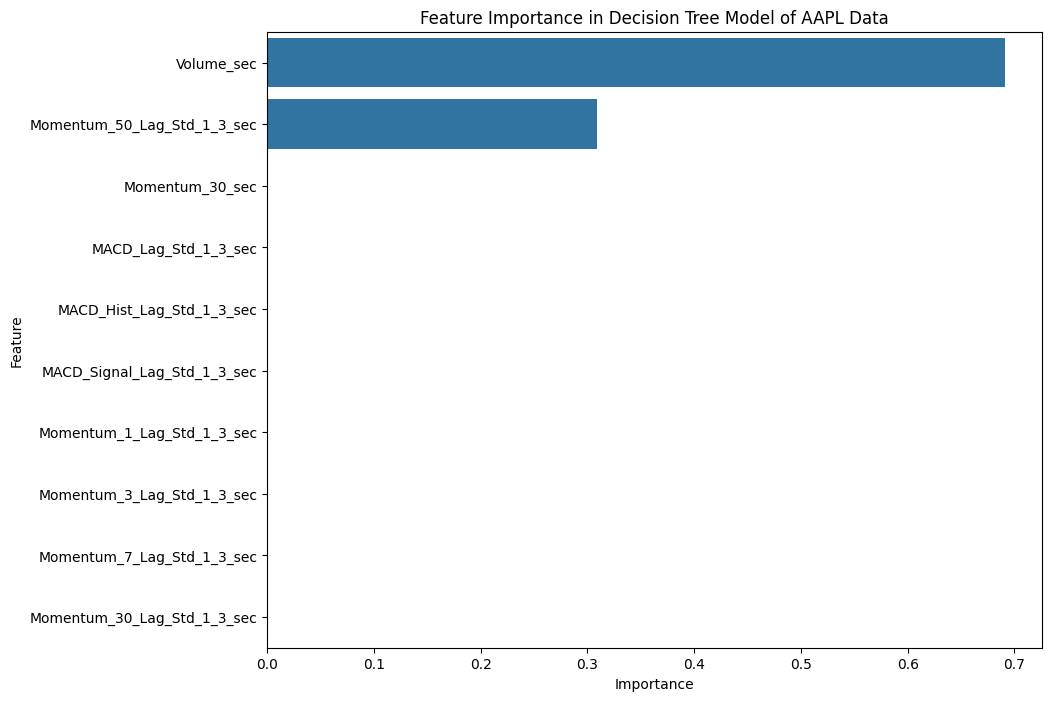

In [13]:
# Let's first make a quick variable for our feature importances to use in the plot.
feature_importances = best_tree.feature_importances_

# make these into a dataframe so they are visualized better
feature_df = pd.DataFrame({'Feature' : X.columns, 'Importance' : feature_importances})

# Sort these features by their importance.
feature_df = feature_df.sort_values(by = 'Importance', ascending=False)

# Now we can plot and see how it looks.
plt.figure(figsize = (10,8))
sns.barplot(x = 'Importance', y = 'Feature', data = feature_df)
plt.title('Feature Importance in Decision Tree Model of AAPL Data')
plt.show()

#### Plot observation here.

#### One more, let's look at an Actual vs Predicted for our values for the AAPL data from our Decision Tree.

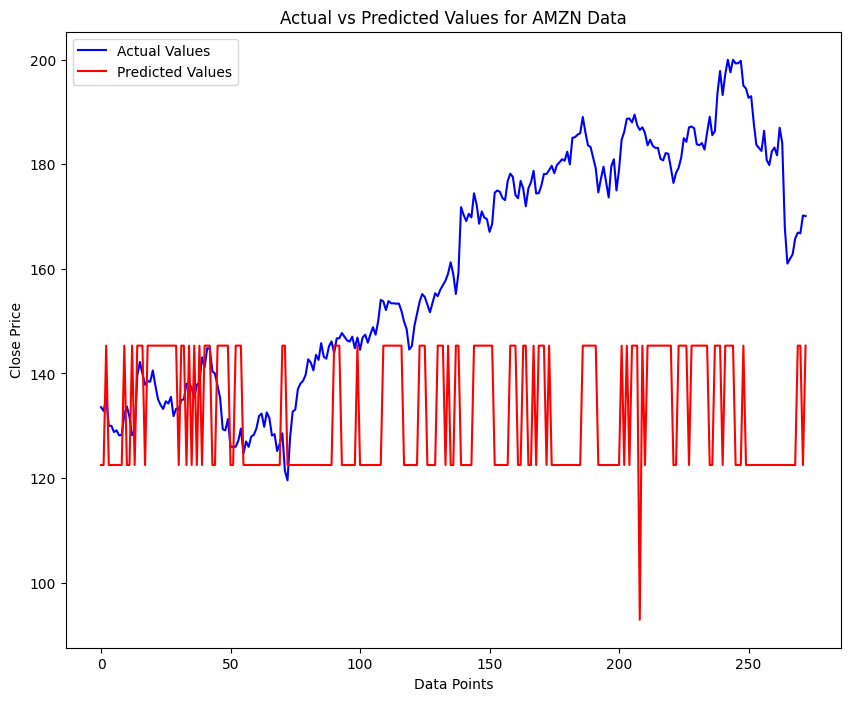

In [14]:
plt.figure(figsize=(10,8))
plt.plot(y_test.values, label = 'Actual Values', color = 'blue')
plt.plot(y_test_pred, label = 'Predicted Values', color = 'red')

plt.title('Actual vs Predicted Values for AMZN Data')
plt.xlabel('Data Points')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### Plot Observation here.

### Notebook Summary.